In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv
/kaggle/input/world-gdpgdp-gdp-per-capita-and-annual-growths/gdp_growth.csv
/kaggle/input/world-gdpgdp-gdp-per-capita-and-annual-growths/gdp_ppp_per_capita.csv
/kaggle/input/world-gdpgdp-gdp-per-capita-and-annual-growths/gdp_ppp.csv
/kaggle/input/world-gdpgdp-gdp-per-capita-and-annual-growths/gdp.csv
/kaggle/input/world-gdpgdp-gdp-per-capita-and-annual-growths/gdp_per_capita.csv
/kaggle/input/world-gdpgdp-gdp-per-capita-and-annual-growths/gdp_per_capita_growth.csv


# Preliminaries 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge

sns.set_style('darkgrid')

In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv", parse_dates=["date"])
original_train_df = train_df.copy()
test_df = pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv", parse_dates=["date"])

# EDA

# Categorical variables 

In [4]:
display(train_df.head(3))
display(test_df.head(3))

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


id       date country              store            product  num_sold
0   0 2010-01-01  Canada  Discount Stickers  Holographic Goose       NaN
1   1 2010-01-01  Canada  Discount Stickers             Kaggle     973.0
2   2 2010-01-01  Canada  Discount Stickers       Kaggle Tiers     906.0

id       date country              store            product
0  230130 2017-01-01  Canada  Discount Stickers  Holographic Goose
1  230131 2017-01-01  Canada  Discount Stickers             Kaggle
2  230132 2017-01-01  Canada  Discount Stickers       Kaggle Tiers

In [5]:
def get_val_counts(df, column_name, sort_by_column_name=False):
    value_count = df[column_name].value_counts().reset_index().rename(columns={column_name:"Value Count","index":column_name}).set_index(column_name)
    value_count["Percentage"] = df[column_name].value_counts(normalize=True)*100
    value_count = value_count.reset_index()
    if sort_by_column_name:
        value_count = value_count.sort_values(column_name)
    return value_count

def plot_value_counts_pie(df, column_name, sort_by_column_name=False):
    val_count_df = get_val_counts(df, column_name, sort_by_column_name)
    val_count.set_index(column_name).plot.pie(y="Value Count", figsize=(5,5), legend=False, ylabel="");

def plot_value_counts_bar(df, column_name, sort_by_column_name = False):
    val_count_df = get_val_counts(df, column_name, sort_by_column_name)
    f,ax = plt.subplots(figsize=(12,6))
    sns.barplot(data = val_count_df, y="Value Count", x=column_name )

    for index, row in val_count_df.iterrows():
        count = row["Value Count"]
        percentage = row["Percentage"]
        ax.text(
            x=index, 
            y=row["Value Count"] + max(val_count_df["Value Count"])*0.02,  # Adjust position slightly above the bar
            s=f'{count} ({percentage:.2f}%)', 
            ha='center', 
            va='bottom'
        )

In [6]:
#plot_value_counts_bar(train_df, 'country')

In [7]:
#plot_value_counts_bar(train_df, "store")

In [8]:
#plot_value_counts_bar(train_df, "product")

In [9]:
counts = train_df.groupby(["country","store","product"])["id"].count().rename("num_rows").reset_index()
counts_val_counts = counts["num_rows"].value_counts().rename("Count").reset_index().rename(columns={"index": "length"})
display(counts_val_counts.head(10))

num_rows  Count
0      2557     90

In [10]:
print(f"Number of missing num_sold rows: {train_df['num_sold'].isna().sum()}")

Number of missing num_sold rows: 8871


In [11]:
counts = train_df.groupby(["country","store","product"])["num_sold"].count().rename("num_rows")
missing_data = counts.loc[counts != 2557]
missing_data_df = missing_data.reset_index()
missing_data_df["num_missing_rows"] = 2557 - missing_data_df["num_rows"]
missing_data_df

country                 store             product  num_rows  \
0  Canada     Discount Stickers   Holographic Goose         0   
1  Canada     Discount Stickers            Kerneler      2556   
2  Canada  Premium Sticker Mart   Holographic Goose      2177   
3  Canada     Stickers for Less   Holographic Goose      1249   
4   Kenya     Discount Stickers   Holographic Goose         0   
5   Kenya     Discount Stickers            Kerneler      2494   
6   Kenya     Discount Stickers  Kerneler Dark Mode      2556   
7   Kenya  Premium Sticker Mart   Holographic Goose      1911   
8   Kenya     Stickers for Less   Holographic Goose      1199   

   num_missing_rows  
0              2557  
1                 1  
2               380  
3              1308  
4              2557  
5                63  
6                 1  
7               646  
8              1358

# Time series

In [12]:
print("Train - Earliest date:", train_df["date"].min())
print("Train - Latest date:", train_df["date"].max())

print("Test - Earliest date:", test_df["date"].min())
print("Test - Latest date:", test_df["date"].max())

Train - Earliest date: 2010-01-01 00:00:00
Train - Latest date: 2016-12-31 00:00:00
Test - Earliest date: 2017-01-01 00:00:00
Test - Latest date: 2019-12-31 00:00:00


In [13]:
weekly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

In [14]:
def plot_all(df):
    f,axes = plt.subplots(3,2,figsize=(25,25), sharex = True, sharey=True)
    f.tight_layout()
    for n,prod in enumerate(df["product"].unique()):
        plot_df = df.loc[df["product"] == prod]
        sns.lineplot(data=plot_df, x="date", y="num_sold", hue="country", style="store",ax=axes[n//2,n%2])
        axes[n//2,n%2].set_title("Product: "+str(prod))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

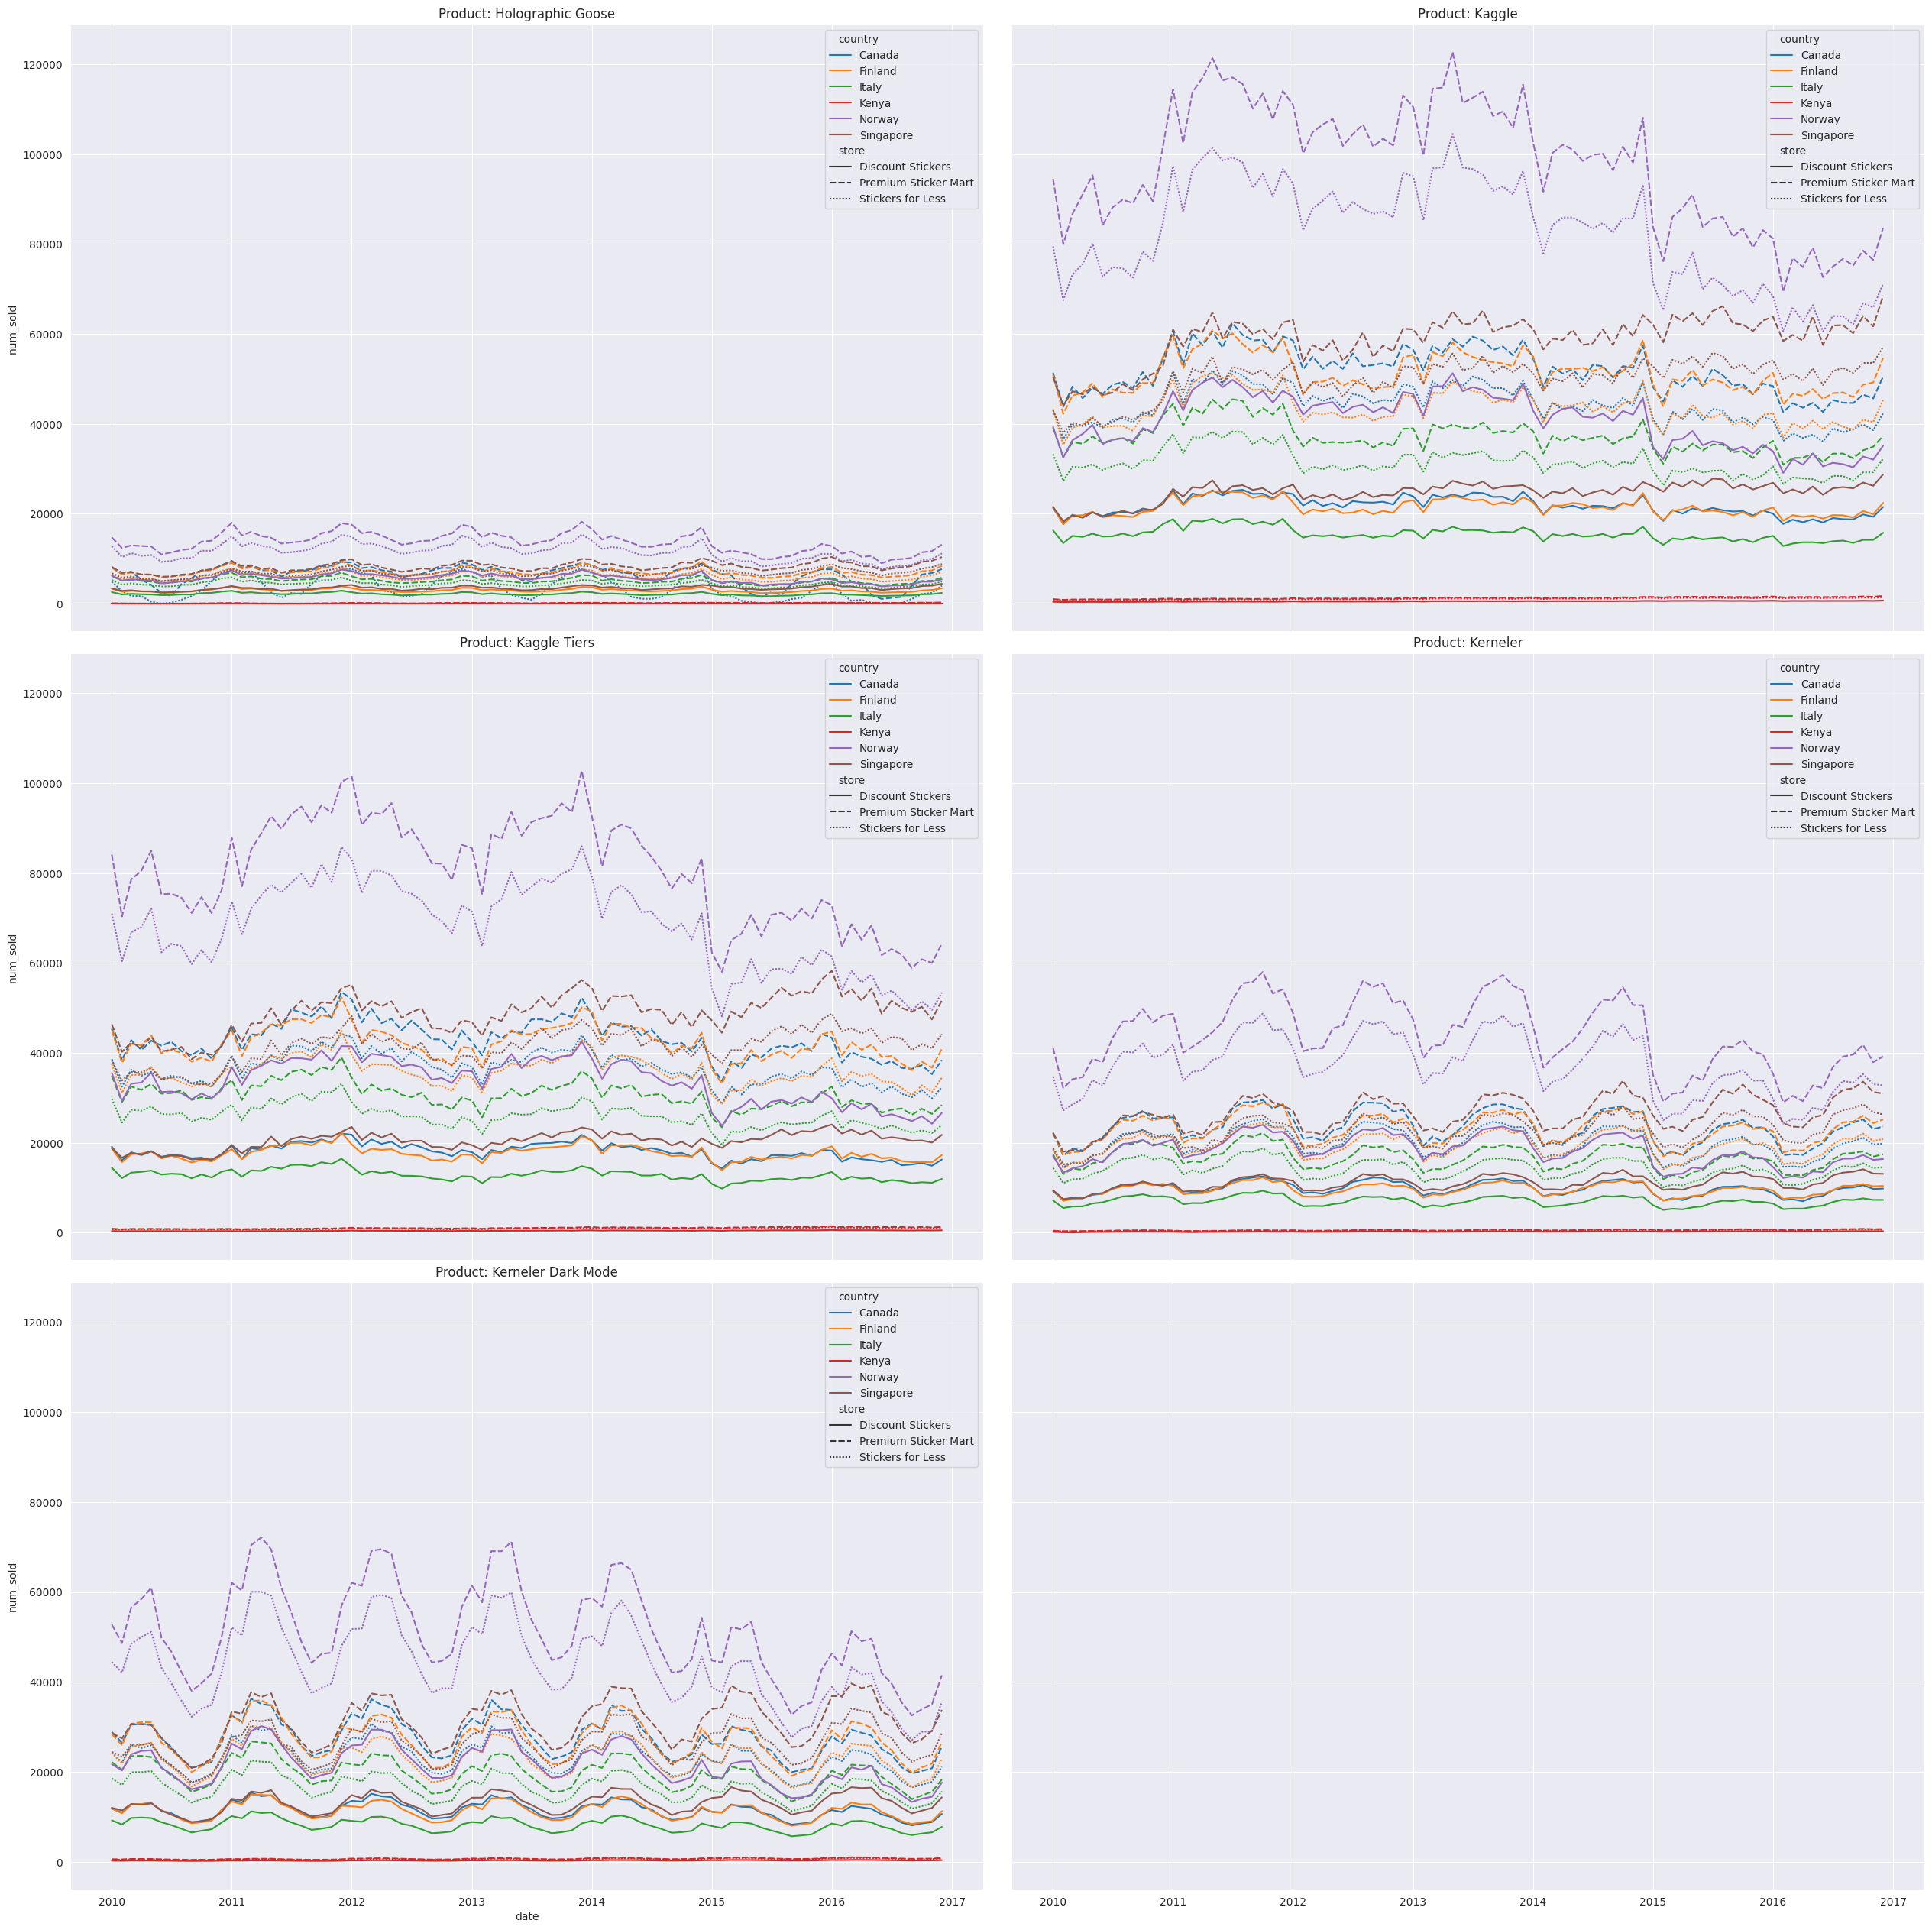

In [15]:
plot_all(monthly_df)
#plot_all(weekly_df)

# Aggregating Time Series

# Country

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

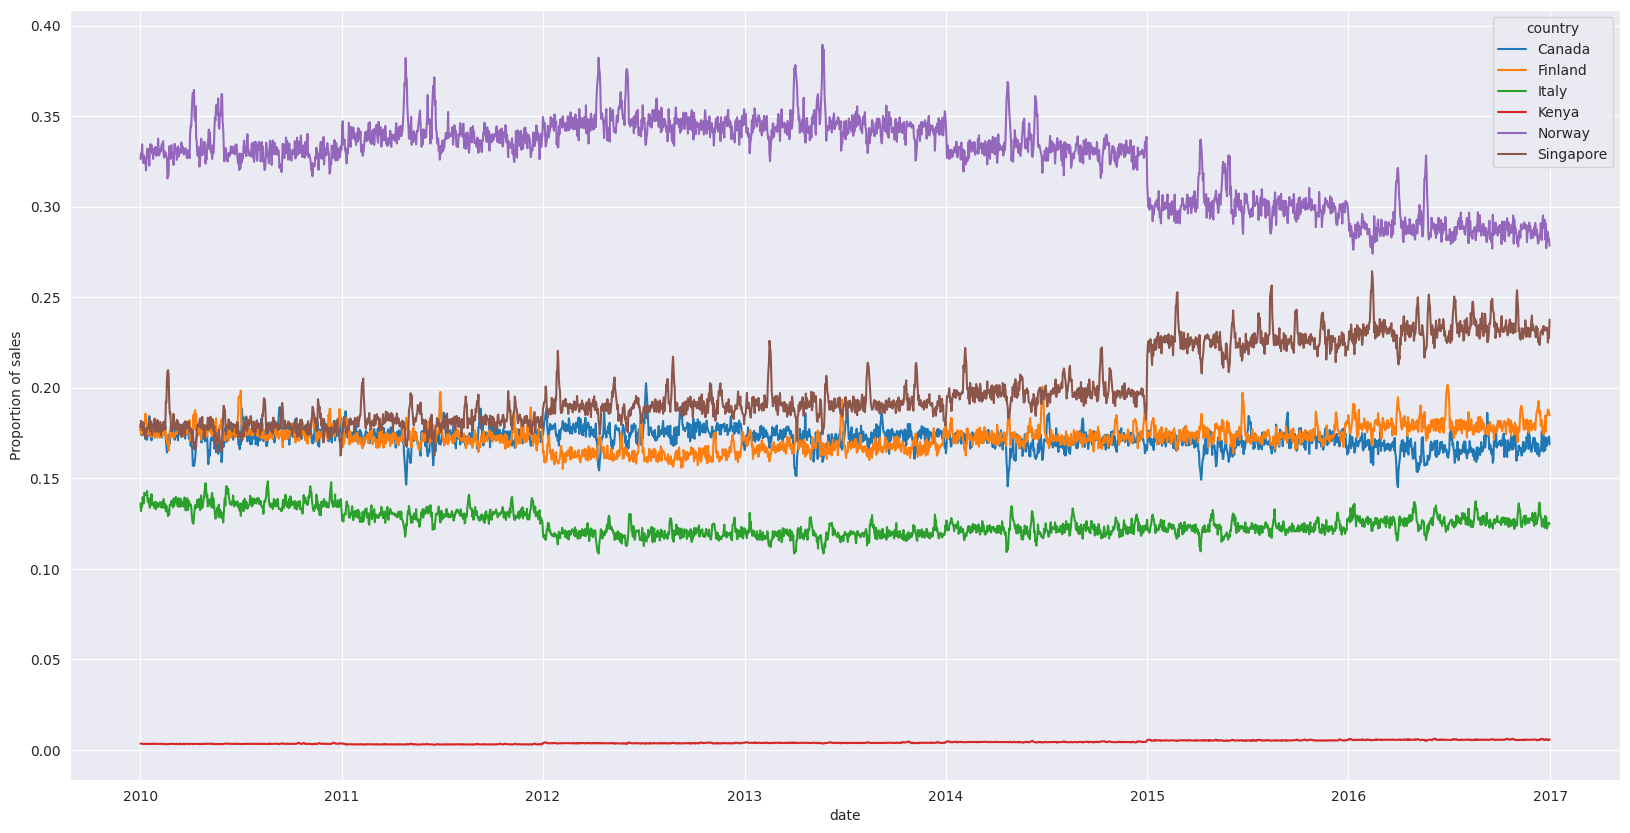

In [16]:
country_weights = train_df.groupby("country")["num_sold"].sum()/train_df["num_sold"].sum()

country_ratio_over_time = (train_df.groupby(["date","country"])["num_sold"].sum() / train_df.groupby(["date"])["num_sold"].sum()).reset_index()
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = country_ratio_over_time, x="date", y="num_sold", hue="country");
ax.set_ylabel("Proportion of sales");

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

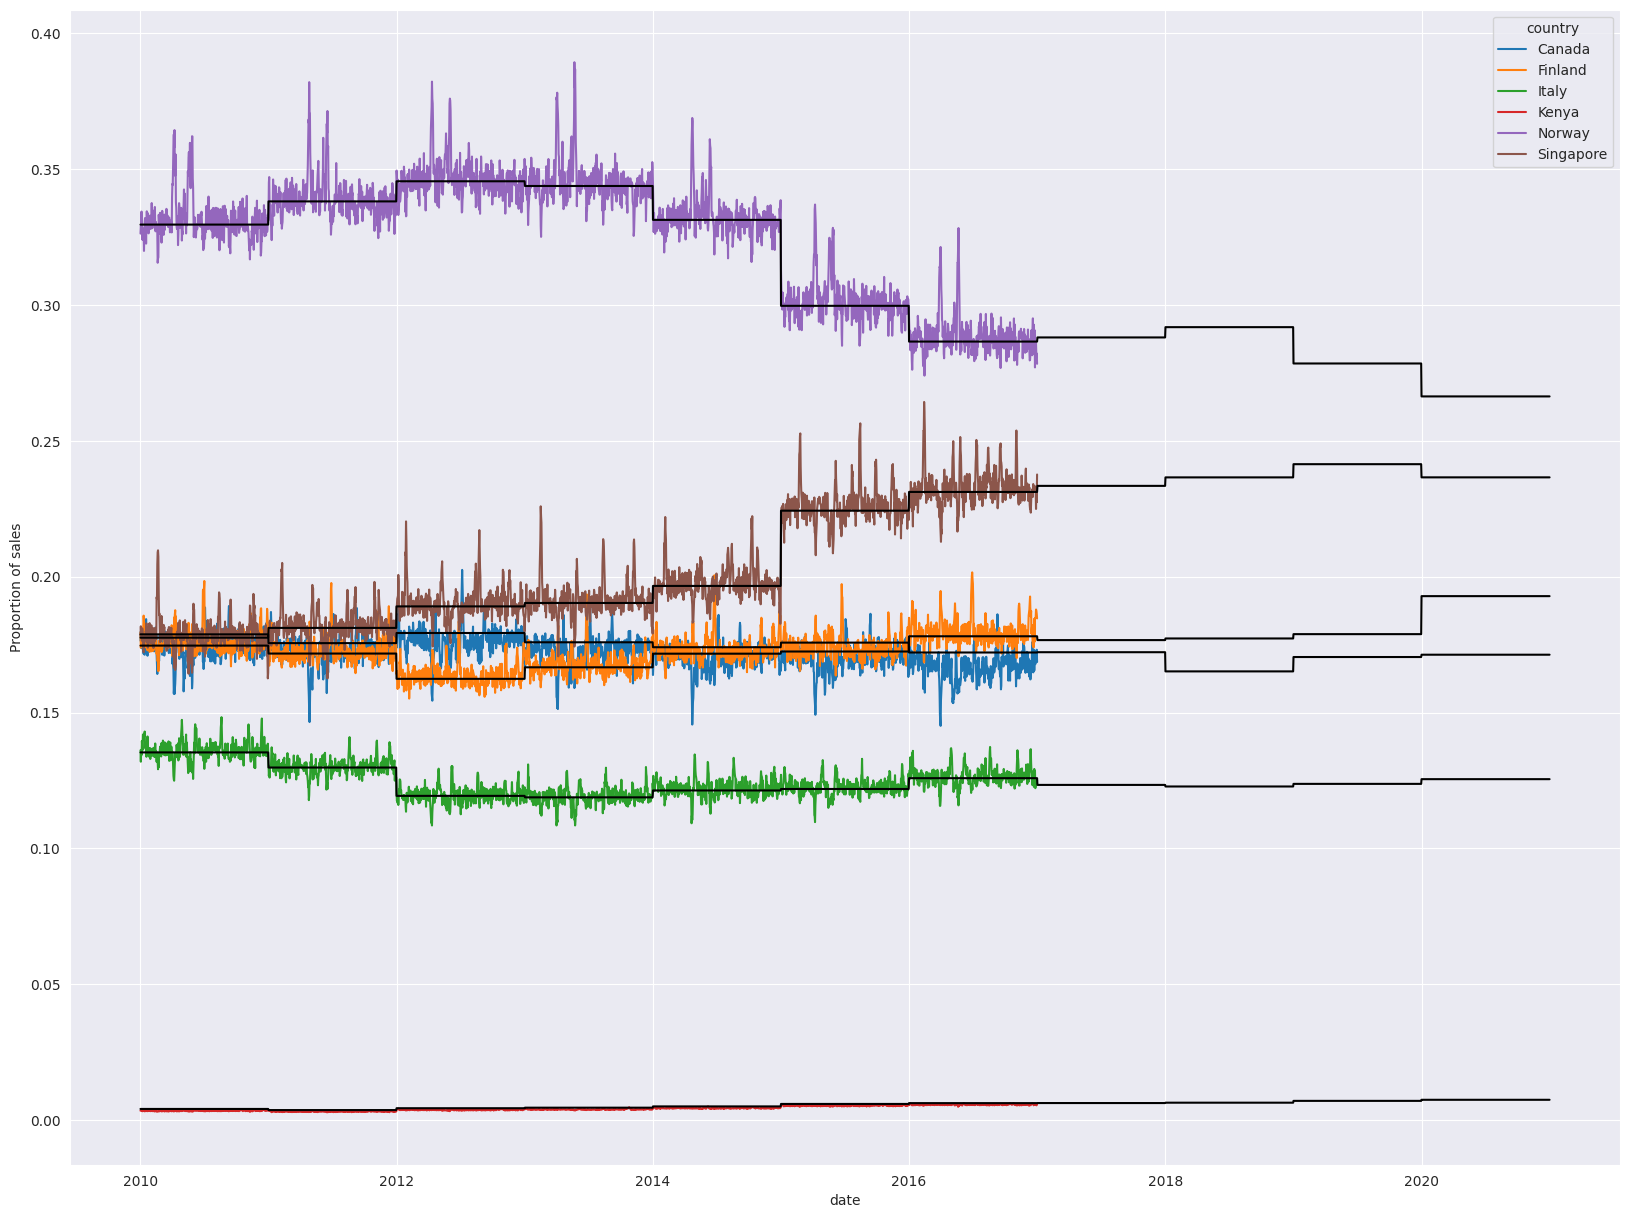

In [17]:
gdp_per_capita_df = pd.read_csv("/kaggle/input/world-gdpgdp-gdp-per-capita-and-annual-growths/gdp_per_capita.csv")

years =  ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
gdp_per_capita_filtered_df = gdp_per_capita_df.loc[gdp_per_capita_df["Country Name"].isin(train_df["country"].unique()), ["Country Name"] + years].set_index("Country Name")
gdp_per_capita_filtered_df["2010_ratio"] = gdp_per_capita_filtered_df["2010"] / gdp_per_capita_filtered_df.sum()["2010"]
for year in years:
    gdp_per_capita_filtered_df[f"{year}_ratio"] = gdp_per_capita_filtered_df[year] / gdp_per_capita_filtered_df.sum()[year]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_df[[i+"_ratio" for i in years]]
gdp_per_capita_filtered_ratios_df.columns = [int(i) for i in years]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_ratios_df.unstack().reset_index().rename(columns = {"level_0": "year", 0: "ratio", "Country Name": "country"})
gdp_per_capita_filtered_ratios_df['year'] = pd.to_datetime(gdp_per_capita_filtered_ratios_df['year'], format='%Y')

# For plotting purposes
gdp_per_capita_filtered_ratios_df_2 = gdp_per_capita_filtered_ratios_df.copy()
gdp_per_capita_filtered_ratios_df_2["year"] = pd.to_datetime(gdp_per_capita_filtered_ratios_df_2['year'].astype(str)) + pd.offsets.YearEnd(1)
gdp_per_capita_filtered_ratios_df = pd.concat([gdp_per_capita_filtered_ratios_df, gdp_per_capita_filtered_ratios_df_2]).reset_index()

f,ax = plt.subplots(figsize=(20,15))
sns.lineplot(data = country_ratio_over_time, x="date", y="num_sold", hue="country");
sns.lineplot(data = gdp_per_capita_filtered_ratios_df, x="year", y = "ratio", hue="country", palette = ["black"]*6, legend = False)
ax.set_ylabel("Proportion of sales");

In [18]:
gdp_per_capita_filtered_ratios_df_2["year"] = gdp_per_capita_filtered_ratios_df_2["year"].dt.year
def plot_adjust_country(df):
    new_df = df.copy()
    new_df["year"] = new_df["date"].dt.year
    
    for country in new_df["country"].unique():
        for year in new_df["year"].unique():
            new_df.loc[(new_df["country"] == country) & (new_df["year"] == year), "num_sold"] = new_df.loc[(new_df["country"] == country) & (new_df["year"] == year), "num_sold"] / gdp_per_capita_filtered_ratios_df_2.loc[(gdp_per_capita_filtered_ratios_df_2["country"] == country) & (gdp_per_capita_filtered_ratios_df_2["year"] == year), "ratio"].values[0]
            
    plot_all(new_df)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

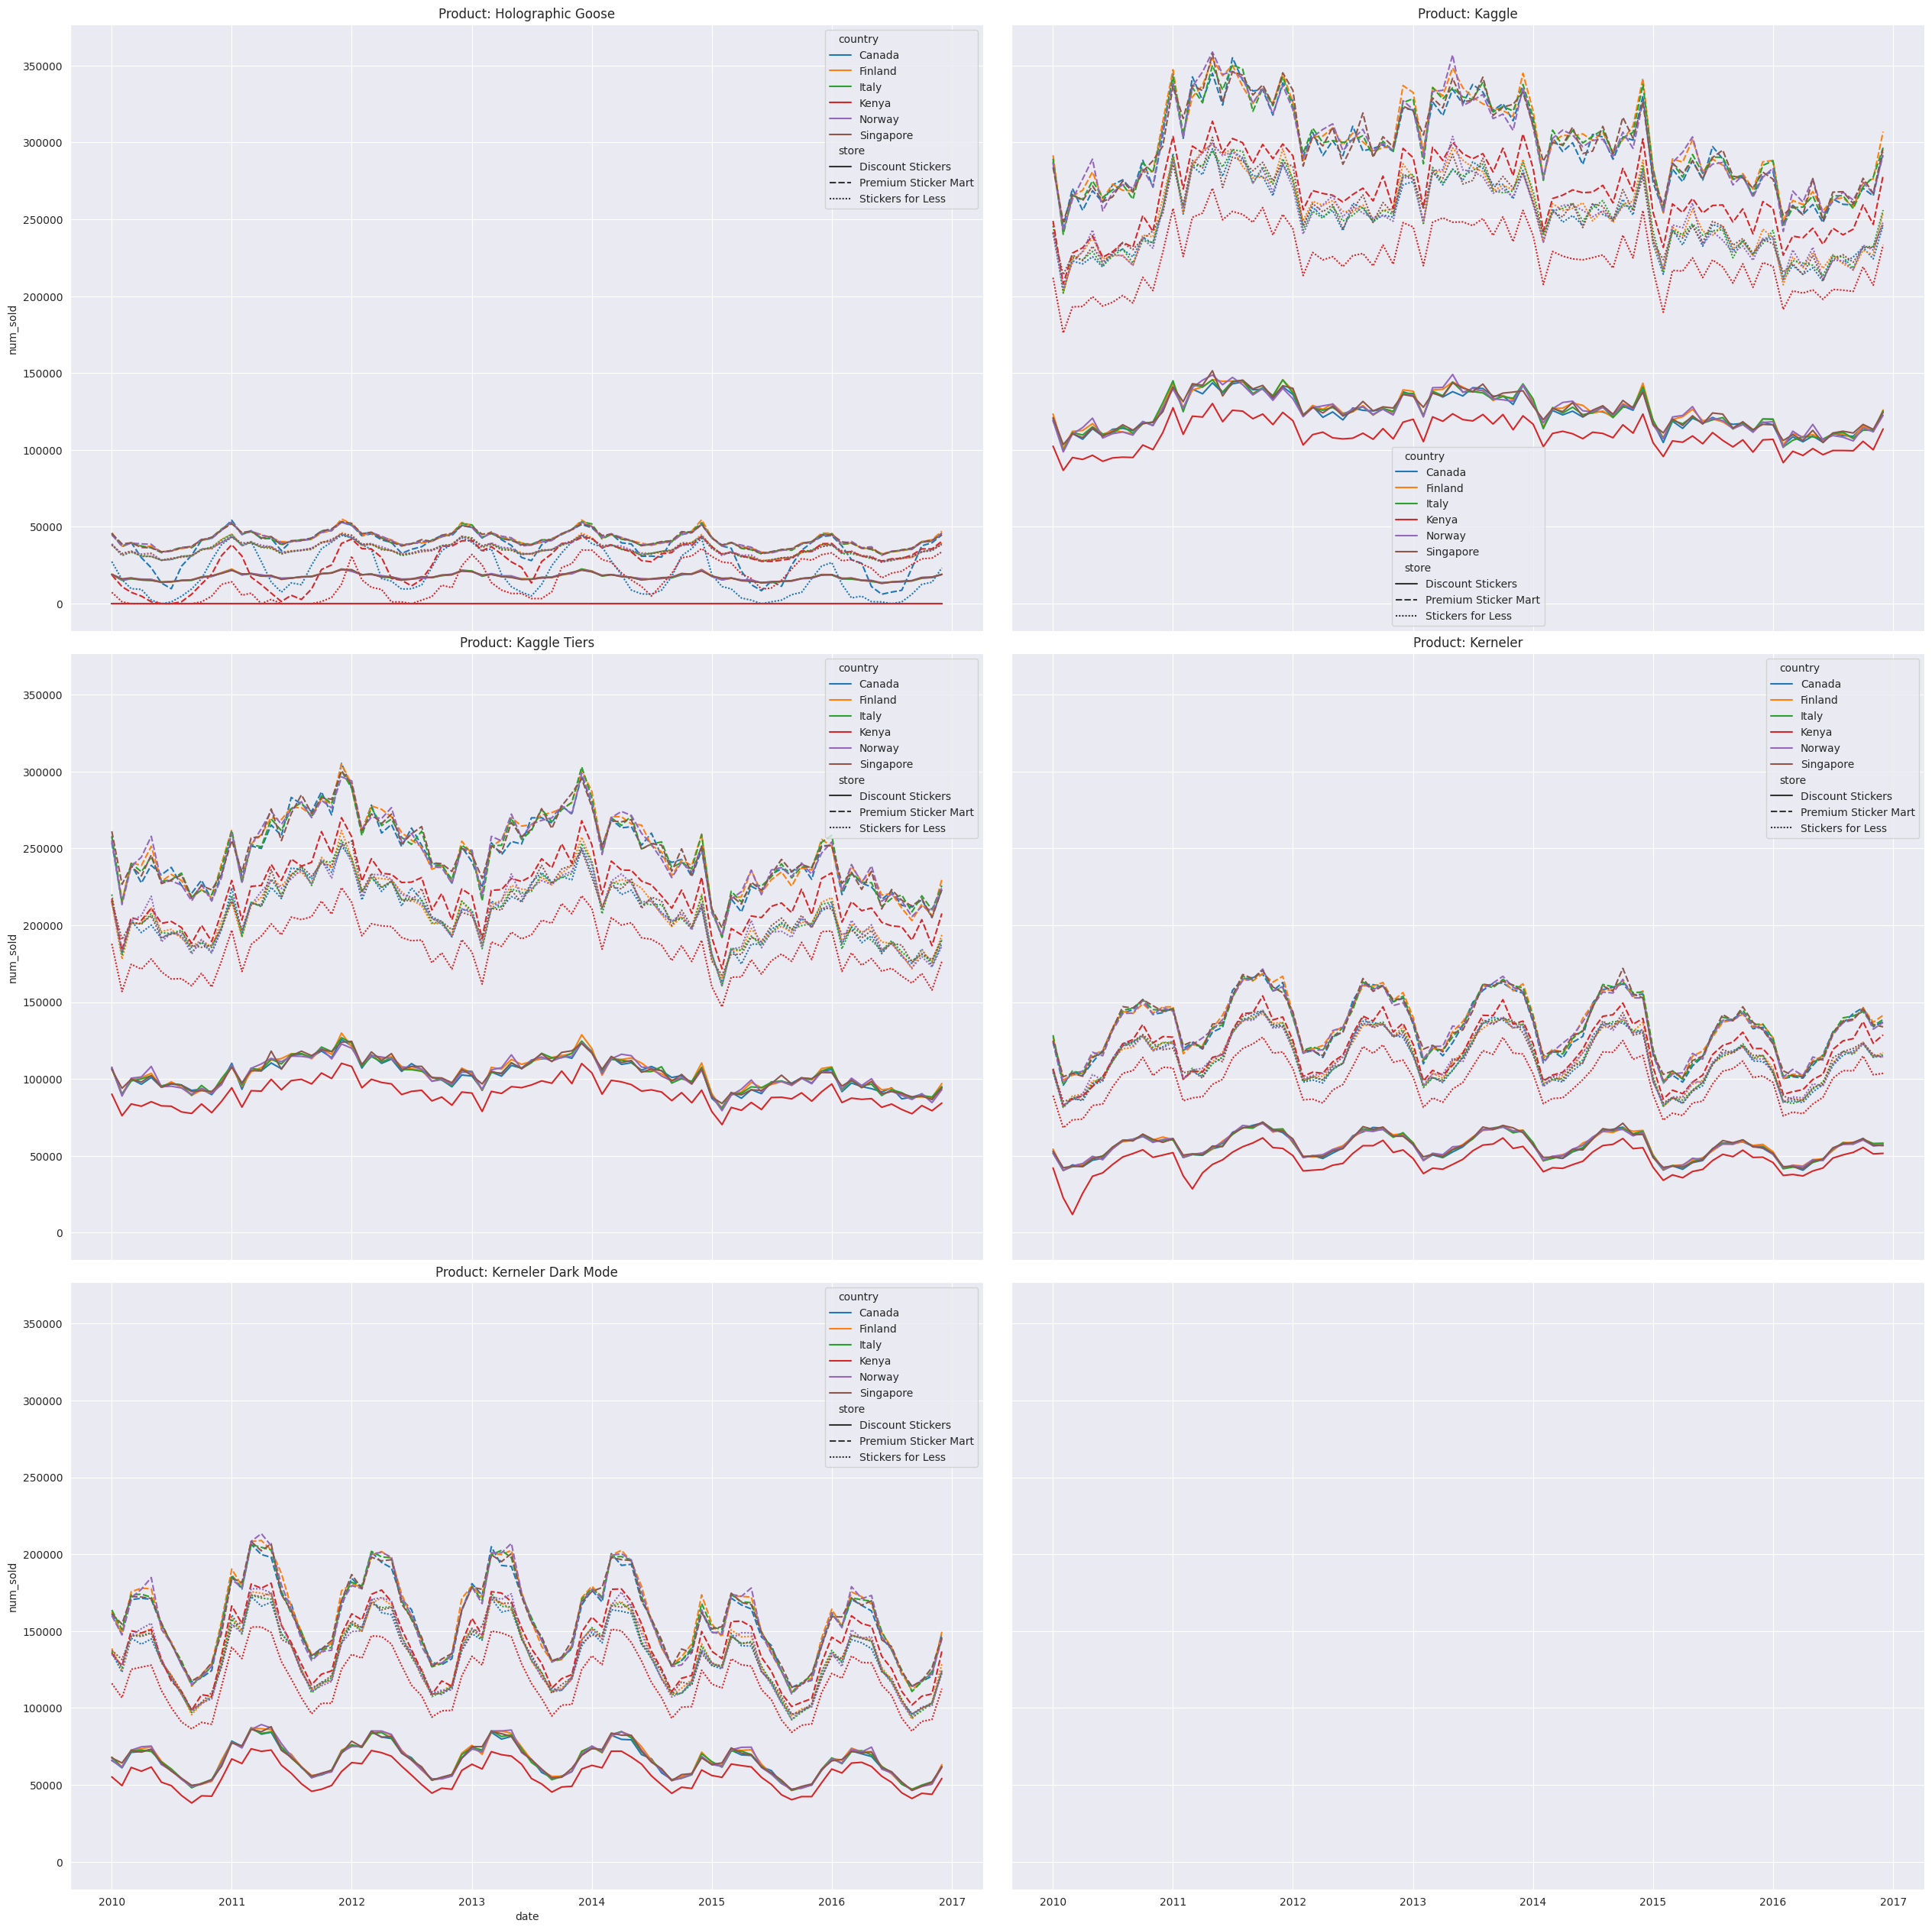

In [19]:
plot_adjust_country(monthly_df)

# Imputing

In [20]:
train_df_imputed = train_df.copy()
print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

train_df_imputed["year"] = train_df_imputed["date"].dt.year
for year in train_df_imputed["year"].unique():
    # Impute Time Series 1 (Canada, Discount Stickers, Holographic Goose)
    target_ratio = gdp_per_capita_filtered_ratios_df_2.loc[(gdp_per_capita_filtered_ratios_df_2["year"] == year) & (gdp_per_capita_filtered_ratios_df_2["country"] == "Norway"), "ratio"].values[0] # Using Norway as should have the best precision
    current_raito = gdp_per_capita_filtered_ratios_df_2.loc[(gdp_per_capita_filtered_ratios_df_2["year"] == year) & (gdp_per_capita_filtered_ratios_df_2["country"] == "Canada"), "ratio"].values[0]
    ratio_can = current_raito / target_ratio
    train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year), "num_sold"] * ratio_can).values
    
    # Impute Time Series 2 (Only Missing Values)
    current_ts =  train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_can).values

    # Impute Time Series 3 (Only Missing Values)
    current_ts =  train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_can).values
    
    # Impute Time Series 4 (Kenya, Discount Stickers, Holographic Goose)
    current_raito = gdp_per_capita_filtered_ratios_df_2.loc[(gdp_per_capita_filtered_ratios_df_2["year"] == year) & (gdp_per_capita_filtered_ratios_df_2["country"] == "Kenya"), "ratio"].values[0]
    ratio_ken = current_raito / target_ratio
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose")& (train_df_imputed["year"] == year), "num_sold"] * ratio_ken).values

    # Impute Time Series 5 (Only Missing Values)
    current_ts = train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_ken).values

    # Impute Time Series 6 (Only Missing Values)
    current_ts = train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_ken).values

    # Impute Time Series 7 (Only Missing Values)
    current_ts = train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_ken).values
    
print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

Missing values remaining: 8871
Missing values remaining: 2


In [21]:
missing_rows = train_df_imputed.loc[train_df_imputed["num_sold"].isna()]
display(missing_rows)
train_df_imputed.loc[train_df_imputed["id"] == 23719, "num_sold"] = 4
train_df_imputed.loc[train_df_imputed["id"] == 207003, "num_sold"] = 195

print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


id       date country              store             product  \
23719    23719 2010-09-21   Kenya  Discount Stickers  Kerneler Dark Mode   
207003  207003 2016-04-19  Canada  Discount Stickers            Kerneler   

        num_sold  year  
23719        NaN  2010  
207003       NaN  2016

Missing values remaining: 0


In [22]:
# Update monthly_df with our imputed data:
weekly_df = train_df_imputed.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train_df_imputed.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

Store

In [23]:
store_weights = train_df_imputed.groupby("store")["num_sold"].sum()/train_df_imputed["num_sold"].sum()
store_weights

store
Discount Stickers       0.184716
Premium Sticker Mart    0.441564
Stickers for Less       0.373720
Name: num_sold, dtype: float64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

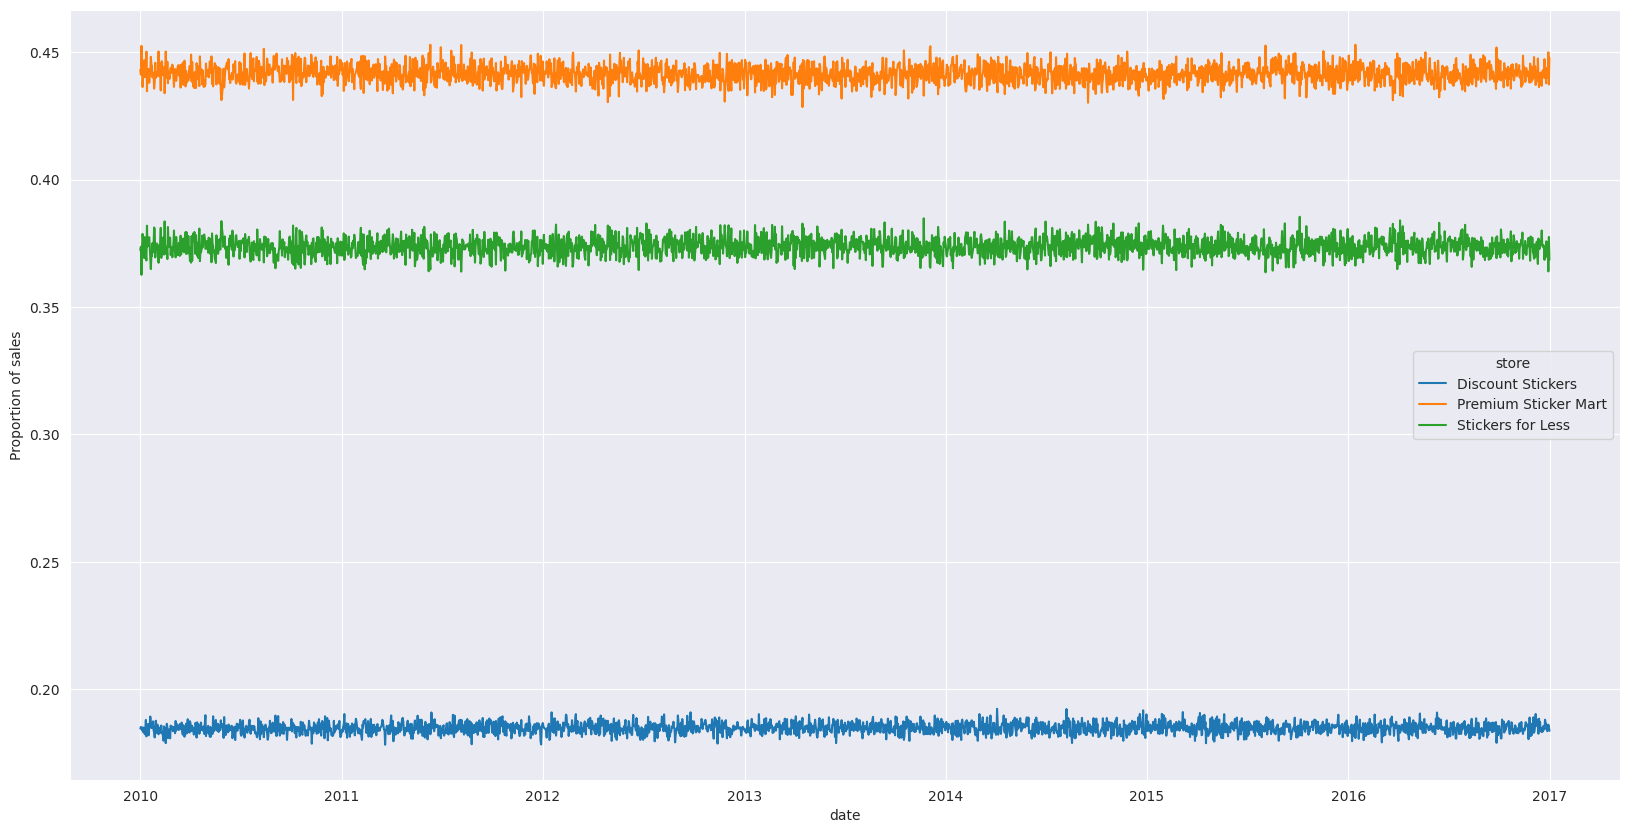

In [24]:
store_ratio_over_time = (train_df_imputed.groupby(["date","store"])["num_sold"].sum() / train_df_imputed.groupby(["date"])["num_sold"].sum()).reset_index()
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = store_ratio_over_time, x="date", y="num_sold", hue="store");
ax.set_ylabel("Proportion of sales");

In [25]:
def plot_adjusted_store(df):
    new_df = df.copy()
    weights = store_weights.loc["Premium Sticker Mart"] / store_weights
    print(weights)
    for store in weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * weights[store]
    plot_all(new_df)

store
Discount Stickers       2.390510
Premium Sticker Mart    1.000000
Stickers for Less       1.181537
Name: num_sold, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

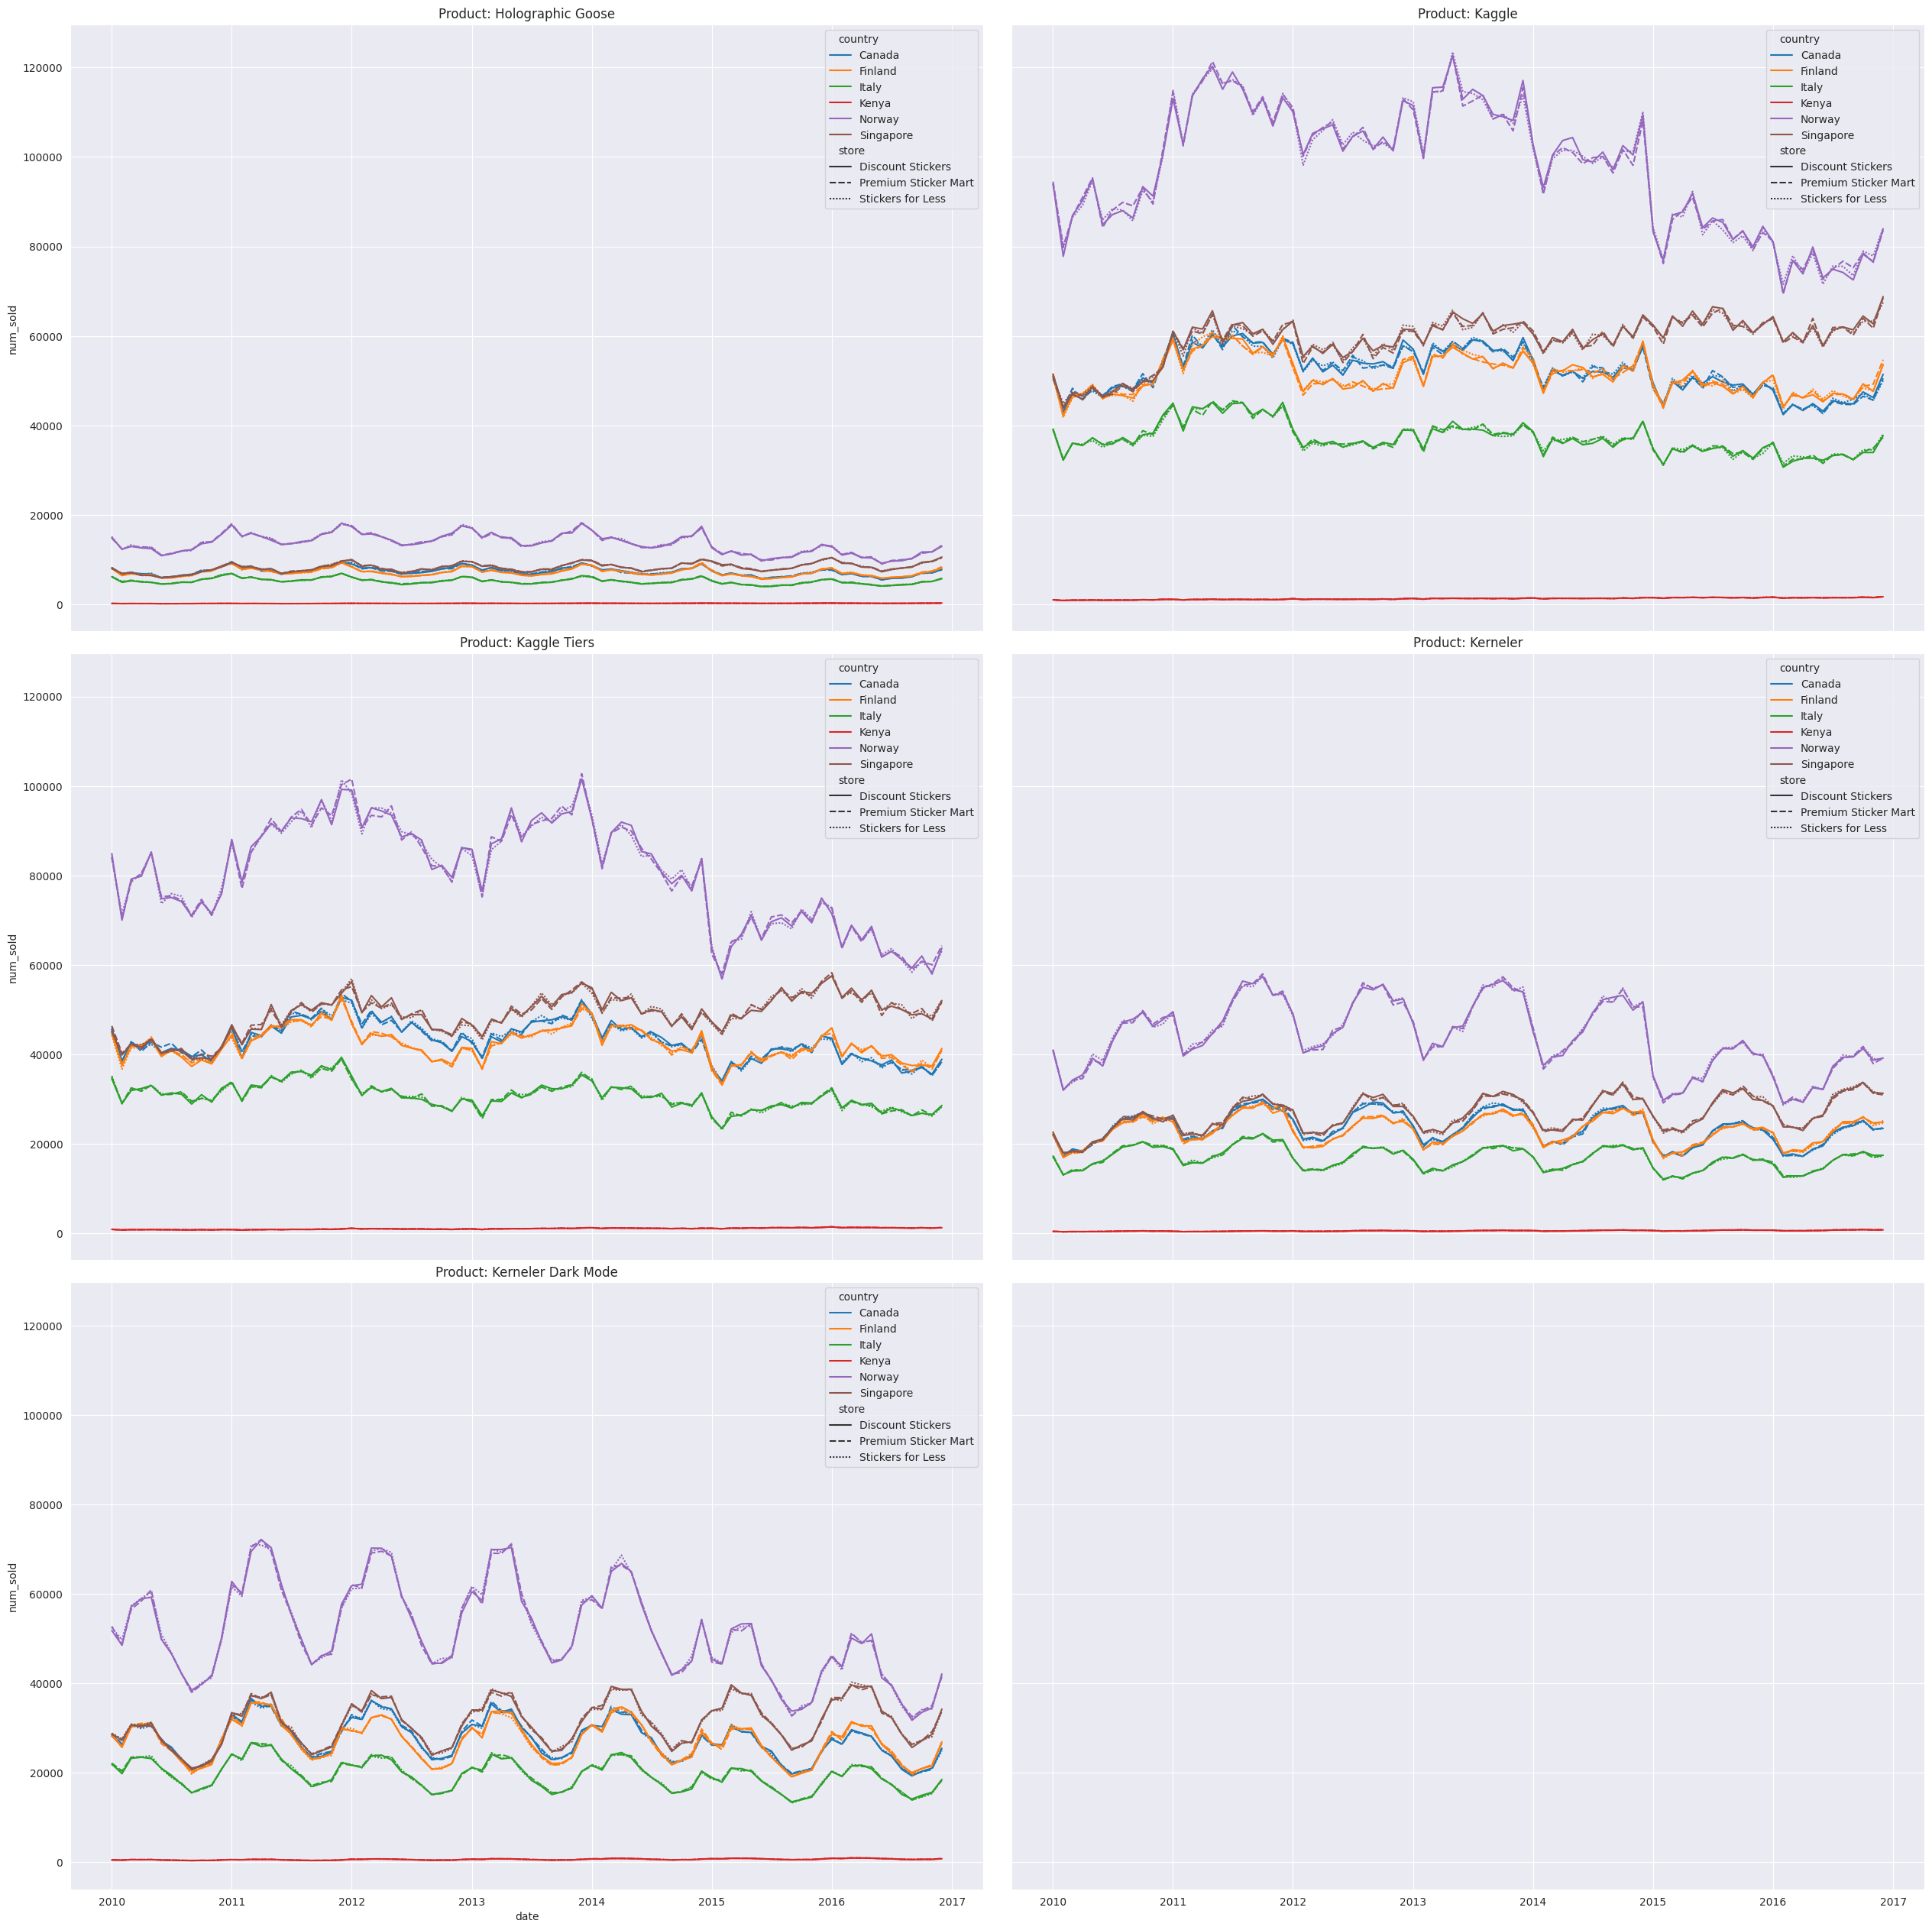

In [26]:
plot_adjusted_store(monthly_df)

In [27]:
product_df = train_df_imputed.groupby(["date","product"])["num_sold"].sum().reset_index()

In [28]:
original_train_df_imputed = train_df_imputed.copy()
train_df_imputed = train_df_imputed.groupby(["date"])["num_sold"].sum().reset_index()

In [29]:
#get the dates to forecast for
test_total_sales_df = test_df.groupby(["date"])["id"].first().reset_index().drop(columns="id")
#keep dates for later
test_total_sales_dates = test_total_sales_df[["date"]]

In [30]:
def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df["day_of_year"] = df['date'].apply(
        lambda x: x.timetuple().tm_yday if not (x.is_leap_year and x.month > 2) else x.timetuple().tm_yday - 1
    )
    new_df['day_sin'] = np.sin(new_df['day_of_year'] * (2 * np.pi /  365.0))
    new_df['day_cos'] = np.cos(new_df['day_of_year'] * (2 * np.pi /  365.0))

    #new_df['week_of_year'] = new_df['date'].dt.isocalendar().week
    
    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,9,10,99, 100, 101, 125,126,355,256,357,358,359,360,361,362,363,364,365] else 0)
    #new_df["year"] = df["date"].dt.year - 2010
    
    new_df = new_df.drop(columns=["date","month","day_of_year"])
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df

In [31]:
train_total_sales_df = feature_engineer(train_df_imputed)
test_total_sales_df = feature_engineer(test_total_sales_df)

In [32]:
display(train_total_sales_df.head(2))
display(test_total_sales_df.head(2))

num_sold  month_sin  month_cos   day_sin   day_cos  important_dates_1  \
0  85710.772635        0.5   0.866025  0.017213  0.999852               True   
1  82699.983533        0.5   0.866025  0.034422  0.999407              False   

   important_dates_2  important_dates_3  important_dates_4  important_dates_5  \
0              False              False              False              False   
1               True              False              False              False   

   ...  important_dates_359  important_dates_360  important_dates_361  \
0  ...                False                False                False   
1  ...                False                False                False   

   important_dates_362  important_dates_363  important_dates_364  \
0                False                False                False   
1                False                False                False   

   important_dates_365  day_of_week_1  day_of_week_2  day_of_week_3  
0                False           True          False          False  
1                False          False           True          False  

[2 rows x 34 columns]

month_sin  month_cos   day_sin   day_cos  important_dates_1  \
0        0.5   0.866025  0.017213  0.999852               True   
1        0.5   0.866025  0.034422  0.999407              False   

   important_dates_2  important_dates_3  important_dates_4  important_dates_5  \
0              False              False              False              False   
1               True              False              False              False   

   important_dates_6  ...  important_dates_359  important_dates_360  \
0              False  ...                False                False   
1              False  ...                False                False   

   important_dates_361  important_dates_362  important_dates_363  \
0                False                False                False   
1                False                False                False   

   important_dates_364  important_dates_365  day_of_week_1  day_of_week_2  \
0                False                False          False          False   
1                False                False          False          False   

   day_of_week_3  
0           True  
1          False  

[2 rows x 33 columns]

In [33]:
y = train_total_sales_df["num_sold"]
X = train_total_sales_df.drop(columns="num_sold")
X_test = test_total_sales_df

In [34]:
model = Ridge(tol=1e-2, max_iter=1000000, random_state=0)
model.fit(X, y)
preds = model.predict(X_test)
test_total_sales_dates["num_sold"] = preds 

In [35]:
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df.head(4)

date            product    ratios
0 2010-01-01  Holographic Goose  0.052441
1 2010-01-01             Kaggle  0.329305
2 2010-01-01       Kaggle Tiers  0.291165
3 2010-01-01           Kerneler  0.152373

In [36]:
product_ratio_2017_df = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2015].copy()
product_ratio_2018_df = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2016].copy()
product_ratio_2019_df = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2015].copy()

product_ratio_2017_df["date"] = product_ratio_2017_df["date"] + pd.DateOffset(years=2)
product_ratio_2018_df["date"] = product_ratio_2018_df["date"] + pd.DateOffset(years=2)
product_ratio_2019_df["date"] =  product_ratio_2019_df["date"] + pd.DateOffset(years=4)

forecasted_ratios_df = pd.concat([product_ratio_2017_df, product_ratio_2018_df, product_ratio_2019_df])

In [37]:
# Adding in the store ratios
store_weights_df = store_weights.reset_index()
test_sub_df = pd.merge(test_df, test_total_sales_dates, how="left", on="date")
test_sub_df = test_sub_df.rename(columns = {"num_sold":"day_num_sold"})
# Adding in the product ratios
test_sub_df = pd.merge(test_sub_df, store_weights_df, how="left", on="store")
test_sub_df = test_sub_df.rename(columns = {"num_sold":"store_ratio"})
# Adding in the country ratios
test_sub_df["year"] = test_sub_df["date"].dt.year
test_sub_df = pd.merge(test_sub_df, gdp_per_capita_filtered_ratios_df_2, how="left", on=["year", "country"])
test_sub_df = test_sub_df.rename(columns = {"ratio":"country_ratio"})
# Adding in the product ratio
test_sub_df = pd.merge(test_sub_df, forecasted_ratios_df, how="left", on=["date", "product"])
test_sub_df = test_sub_df.rename(columns = {"ratios":"product_ratio"})

# Disaggregating the forecast
test_sub_df["num_sold"] = test_sub_df["day_num_sold"] * test_sub_df["store_ratio"] * test_sub_df["country_ratio"] * test_sub_df["product_ratio"]
test_sub_df["num_sold"] = test_sub_df["num_sold"].round()
display(test_sub_df.head(2))

id       date country              store            product  \
0  230130 2017-01-01  Canada  Discount Stickers  Holographic Goose   
1  230131 2017-01-01  Canada  Discount Stickers             Kaggle   

   day_num_sold  store_ratio  year  country_ratio  product_ratio  num_sold  
0  88797.943799     0.184716  2017        0.17221       0.053755     152.0  
1  88797.943799     0.184716  2017        0.17221       0.350044     989.0

In [38]:
submission = pd.read_csv("/kaggle/input/playground-series-s5e1/sample_submission.csv")
submission["num_sold"] = test_sub_df["num_sold"]
submission.to_csv("submission.csv", index=False)
display(submission.head(2))

id  num_sold
0  230130     152.0
1  230131     989.0